In [179]:
!pip install datasets

In [180]:
from datasets import list_datasets

In [181]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

In [182]:
from datasets import load_dataset

In [183]:
emotions = load_dataset("emotion")
emotions

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [184]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [185]:
len(train_ds)

16000

In [186]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [187]:
train_ds.column_names

['text', 'label']

In [188]:
print(train_ds.features)

In [189]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [190]:
import pandas as pd

In [191]:
emotions.set_format(type="pandas")

In [192]:
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [193]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)


In [194]:
df["label_name"] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Visualization

In [195]:
import matplotlib.pyplot as plt

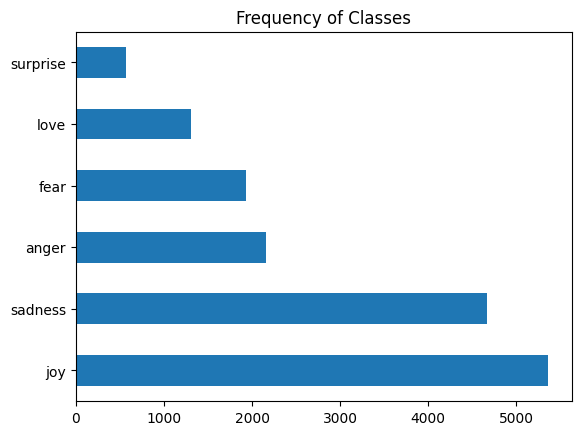

In [196]:
df["label_name"].value_counts().plot.barh()
plt.title("Frequency of Classes")
plt.show()

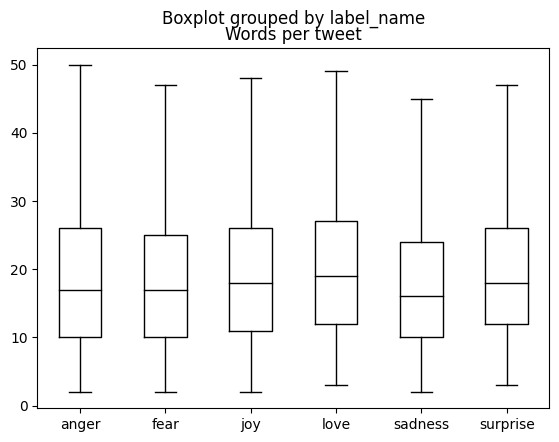

In [197]:
df["Words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.xlabel("")
plt.show()

In [198]:
emotions.reset_format()

# Text to Tokens

In [199]:
!pip install transformers

In [200]:
from transformers import AutoTokenizer

In [201]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [202]:
from transformers import DistilBertTokenizer

In [203]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [204]:
text = "Tokenizing text is a core task of NLP"

In [205]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [206]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '[SEP]']

In [207]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp [SEP]'

In [208]:
tokenizer.vocab_size

30522

In [209]:
tokenizer.model_max_length

512

In [210]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

# Tokenizing the whole dataset

In [211]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [212]:
print(tokenize(emotions['train'][:2]))

In [213]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [214]:
print(emotions_encoded['train'].column_names)

# Feature Extraction

In [215]:
from transformers import AutoModel
import torch

In [216]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [217]:
text = "This is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

In [218]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [219]:
inputs.items()

dict_items([('input_ids', tensor([[ 101, 2023, 2003, 1037, 3231,  102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])

In [220]:
inputs = {k: v.to(device) for k, v in inputs.items()}

In [221]:
with torch.no_grad():
    output = model(**inputs)

print(output)

In [222]:
output.last_hidden_state.size()

torch.Size([1, 6, 768])

In [223]:
output.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [224]:
output.last_hidden_state[:, 0]

tensor([[-1.5651e-01, -1.8620e-01,  5.2777e-02, -1.0634e-01, -1.3163e-02,
         -2.6944e-01,  9.2270e-02,  1.5865e-01, -9.8675e-02, -2.9572e-01,
         -1.3788e-01, -3.8061e-02, -5.3617e-02,  1.3045e-01,  3.9713e-02,
          8.6893e-02,  2.5087e-02,  8.6177e-03,  2.5243e-01, -1.3678e-01,
         -1.2137e-01, -1.3896e-01, -1.3426e-01, -9.0844e-02,  3.0509e-02,
         -3.8619e-02,  1.1485e-01, -5.7996e-02,  1.0131e-01,  9.7920e-02,
          3.8742e-03,  1.1950e-01, -6.6339e-02, -2.1257e-02,  1.3090e-01,
          2.6520e-02,  2.3624e-01,  5.0220e-02,  1.3503e-02, -2.1379e-02,
         -8.8323e-02, -9.8360e-02,  2.2675e-01, -2.4940e-02, -1.6261e-01,
         -8.3787e-02, -1.9629e+00, -1.4541e-01, -1.5582e-01, -3.5487e-01,
         -4.5971e-02,  2.0034e-01,  1.3080e-02,  4.9650e-01,  1.0587e-01,
          1.2080e-01, -1.9118e-01,  3.8280e-01,  1.7121e-02, -1.6627e-02,
          2.1525e-01,  4.4381e-02,  3.9333e-03,  3.5416e-02,  1.2238e-01,
          2.1459e-01,  1.5014e-02,  2.

In [225]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    # Extract last hidden state
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return the vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}


In [226]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [227]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [228]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [229]:
emotions_hidden["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 16000
})

In [230]:
import numpy as np

In [231]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_val = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_val= np.array(emotions_hidden["validation"]["label"])

In [232]:
X_train.shape, X_val.shape

((16000, 768), (2000, 768))

# Visualization

In [233]:
!pip3 install umap-learn

In [234]:
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler

In [235]:
X_scaled = MinMaxScaler().fit_transform(X_train)

In [236]:
mapper = UMAP(n_components = 2, metric="cosine").fit(X_train)

In [237]:
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])

In [238]:
y_train

array([0, 0, 3, ..., 1, 3, 0])

In [239]:
df_emb["label"] = y_train

In [240]:
df_emb.head()

,X,Y,label
0,5.922077,4.284259,0
1,-2.007113,7.713027,0
2,8.214698,5.293639,3
3,-0.815482,5.826106,2
4,-2.433074,5.474655,3


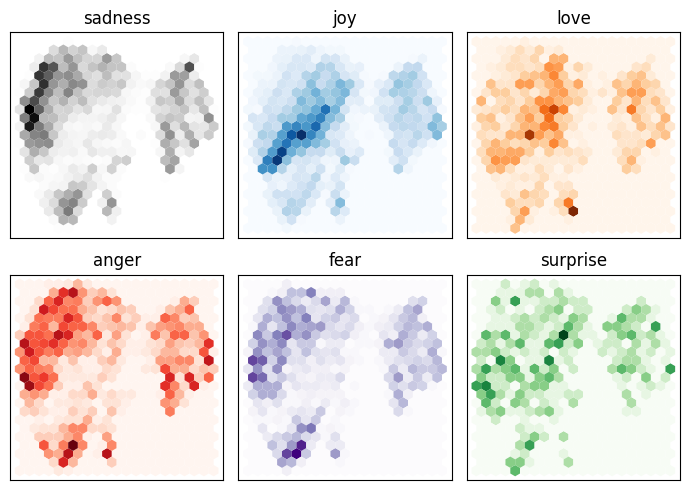

In [241]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Classification

In [242]:
from sklearn.linear_model import LogisticRegression

In [243]:
lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_val, y_val)

0.634

In [244]:
from sklearn.dummy import DummyClassifier

In [245]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_val, y_val)

0.352

In [246]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [247]:
def plot_confusion_matrix(y_pred, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

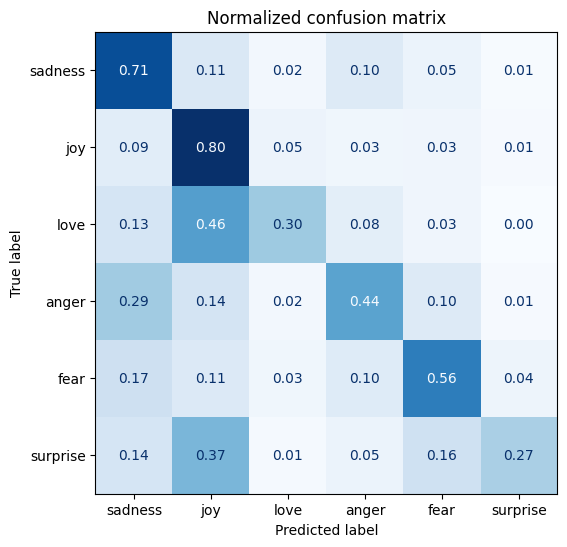

In [248]:
y_preds = lr_clf.predict(X_val)
plot_confusion_matrix(y_preds, y_val, labels)

# Fine Tuning

In [348]:
from transformers import AutoModelForSequenceClassification

In [349]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

In [350]:
from sklearn.metrics import accuracy_score, f1_score

In [351]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [352]:
from huggingface_hub import notebook_login

In [353]:
notebook_login()

In [354]:
from transformers import Trainer, TrainingArguments

In [355]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion-dataset"

In [264]:
# !pip uninstall transformers
!pip install transformers[torch]

In [356]:
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [357]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train()

Cloning https://huggingface.co/ronit33/distilbert-base-uncased-finetuned-emotion-dataset into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.838600,0.327559,0.904000,0.901081
2,0.257200,0.230037,0.918000,0.918345


TrainOutput(global_step=500, training_loss=0.547917465209961, metrics={'train_runtime': 235.9639, 'train_samples_per_second': 135.614, 'train_steps_per_second': 2.119, 'total_flos': 720342861696000.0, 'train_loss': 0.547917465209961, 'epoch': 2.0})

In [358]:
preds_output=trainer.predict(emotions_encoded["validation"])

In [359]:
preds_output.metrics

{'test_loss': 0.2300371378660202,
 'test_accuracy': 0.918,
 'test_f1': 0.9183451843024099,
 'test_runtime': 4.0145,
 'test_samples_per_second': 498.19,
 'test_steps_per_second': 7.971}

In [360]:
y_preds = np.argmax(preds_output.predictions, axis=1)

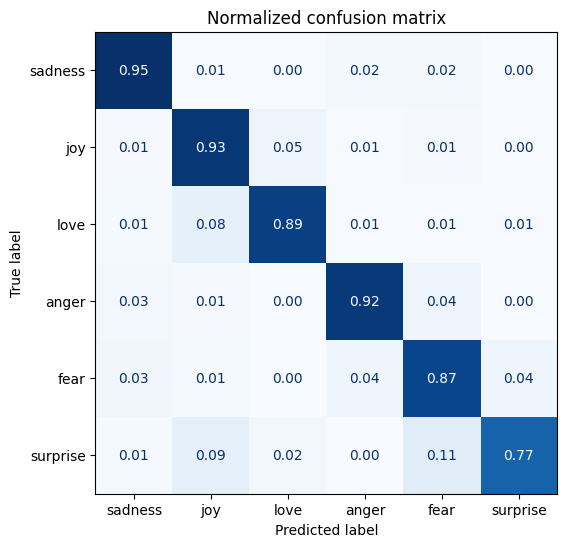

In [361]:
plot_confusion_matrix(y_preds, y_val, labels)

# Saving and Sharing

In [362]:
trainer.push_to_hub(commit_message="Training completed")

Upload file runs/Jun26_06-42-54_c87b4ee4e090/events.out.tfevents.1687761784.c87b4ee4e090.3949.2: 100%|########…

To https://huggingface.co/ronit33/distilbert-base-uncased-finetuned-emotion-dataset
   ca69789..ff32af0  main -> main

   ca69789..ff32af0  main -> main

To https://huggingface.co/ronit33/distilbert-base-uncased-finetuned-emotion-dataset
   ff32af0..c5db570  main -> main

   ff32af0..c5db570  main -> main



'https://huggingface.co/ronit33/distilbert-base-uncased-finetuned-emotion-dataset/commit/ff32af09f8b6191fe860e63c541cdc9638187927'

In [389]:
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt

def predict(custom_tweet):
  
  labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

  
  model_id = "ronit33/distilbert-base-uncased-finetuned-emotion-dataset"
  classifier = pipeline('text-classification', model=model_id)

  preds = classifier(custom_tweet, return_all_scores=True)

  preds_df = pd.DataFrame(preds[0])

  plt.bar(labels, 100*preds_df['score'], color='C0')
  plt.title(f"{custom_tweet}")
  plt.ylabel("Class probability (%)")
  plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


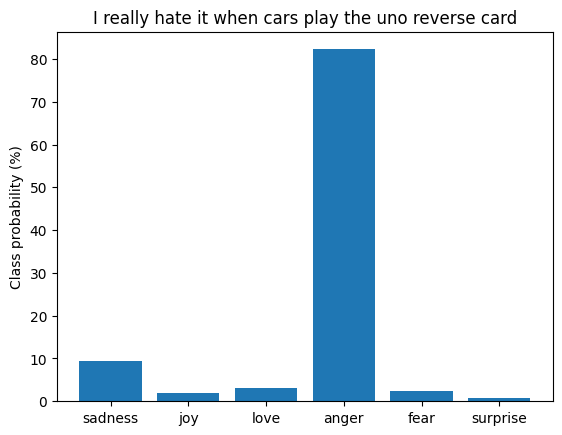

In [395]:
predict('I really hate it when cars play the uno reverse card')